# Choice Model Calibration Analysis

This notebook analyzes how the intercept parameter in the choice model affects trip acceptance rates for the NYC Manhattan scenario at hour 19.

## 1. Import Libraries

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

# Set plot style for professional appearance
plt.style.use('seaborn-v0_8-paper')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12

## 2. Define Choice Model Parameters

These are the fixed parameters from the codebase (`src/envs/amod_env_multi.py`).

In [2]:
# Fixed choice model parameters from the code
INTERCEPT_DEFAULT = 13.5  # Default intercept value
TRAVEL_TIME_COEF = -0.71  # Coefficient for travel time
WAGE = 25  # Hourly wage in dollars
INCOME_EFFECT = 25 / WAGE  # Income effect multiplier
CHOICE_PRICE_MULT = 1.0  # Default price multiplier
U_REJECT = 0  # Utility of rejecting the trip (outside option)

print("Choice Model Parameters:")
print(f"  Intercept (default): {INTERCEPT_DEFAULT}")
print(f"  Travel time coefficient: {TRAVEL_TIME_COEF}")
print(f"  Wage: ${WAGE}/hour")
print(f"  Income effect: {INCOME_EFFECT}")
print(f"  Price multiplier: {CHOICE_PRICE_MULT}")
print(f"  Rejection utility: {U_REJECT}")

Choice Model Parameters:
  Intercept (default): 13.5
  Travel time coefficient: -0.71
  Wage: $25/hour
  Income effect: 1.0
  Price multiplier: 1.0
  Rejection utility: 0


## 3. Load NYC Manhattan Scenario Data

In [3]:
# Load the scenario data
with open('data/scenario_nyc_manhattan.json', 'r') as f:
    scenario_data = json.load(f)

print(f"Scenario loaded successfully")
print(f"Number of nodes: {scenario_data['nlat']}")
print(f"Number of demand entries: {len(scenario_data['demand'])}")
print(f"Total demand (all hours): {sum(trip['demand'] for trip in scenario_data['demand']):.0f} passengers")

Scenario loaded successfully
Number of nodes: 12
Number of demand entries: 14097
Total demand (all hours): 85994 passengers


## 4. Filter Demand for Hour 19

In [4]:
# Filter demand for hour 19
# Hour 19 = 19:00-19:59, which corresponds to minutes 1140-1199 (19*60 to 20*60-1)
hour_19_start = 19 * 60  # 1140
hour_19_end = 20 * 60    # 1200

demand_hour_19 = [
    trip for trip in scenario_data['demand'] 
    if hour_19_start <= trip['time_stamp'] < hour_19_end
]

print(f"\nDemand trips at hour 19:")
print(f"  Number of O-D pair entries: {len(demand_hour_19)}")
print(f"  Total demand (passengers): {sum(trip['demand'] for trip in demand_hour_19):.0f}")
print(f"  Time range: minute {hour_19_start} to {hour_19_end-1} (hour 19:00-19:59)")

# Show sample of data
print(f"\nSample trip:")
if demand_hour_19:
    sample = demand_hour_19[0]
    print(f"  Time stamp: {sample['time_stamp']} (minute of day)")
    print(f"  Origin: {sample['origin']}, Destination: {sample['destination']}")
    print(f"  Travel time: {sample['travel_time']} min")
    print(f"  Price: ${sample['price']:.2f}")
    print(f"  Demand: {sample['demand']:.2f}")


Demand trips at hour 19:
  Number of O-D pair entries: 4677
  Total demand (passengers): 30866
  Time range: minute 1140 to 1199 (hour 19:00-19:59)

Sample trip:
  Time stamp: 1140 (minute of day)
  Origin: 0, Destination: 0
  Travel time: 6 min
  Price: $8.04
  Demand: 3.00


In [6]:
# Scale demand by factor of 2
DEMAND_SCALE_FACTOR = 2

print(f"\nScaling demand by factor of {DEMAND_SCALE_FACTOR}")
print(f"Original total demand: {sum(trip['demand'] for trip in demand_hour_19):.0f} passengers")

# Scale the demand for each OD pair
for trip in demand_hour_19:
    trip['demand'] = trip['demand'] * DEMAND_SCALE_FACTOR

print(f"Scaled total demand: {sum(trip['demand'] for trip in demand_hour_19):.0f} passengers")
print(f"Number of O-D pairs (unchanged): {len(demand_hour_19)}")


Scaling demand by factor of 2
Original total demand: 30866 passengers
Scaled total demand: 61732 passengers
Number of O-D pairs (unchanged): 4677


## 5. Analyze Trip Acceptance Across Intercept Values

## 6. Create Professional Visualization

In [7]:
# Define range of intercept values to test (focused around 50% acceptance for nice S-curve)
intercept_range = np.linspace(6, 20, 100)

# Calculate total demand
total_demand = sum(int(trip['demand']) for trip in demand_hour_19)

print("Two-agent Monte Carlo choice model simulation")
print(f"Testing {len(intercept_range)} intercept values from {intercept_range[0]} to {intercept_range[-1]}")
print(f"Focused range to capture S-curve around 50% acceptance")
print(f"Total demand: {total_demand} trips\n")

# Run simulations
n_simulations = 50
proportion_accepted = []
accepted_demand_values = []

for intercept in tqdm(intercept_range, desc="Testing intercept values"):
    accepted_counts = []
    
    # Run multiple Monte Carlo simulations
    for sim in range(n_simulations):
        total_accepted = 0
        
        for trip in demand_hour_19:
            # Calculate utilities for both agents (same price for both in baseline)
            travel_time_hours = trip['travel_time'] / 60
            U_agent = intercept - TRAVEL_TIME_COEF * WAGE * travel_time_hours - INCOME_EFFECT * CHOICE_PRICE_MULT * trip['price']
            
            # Multinomial logit probabilities: agent0, agent1, reject
            exp_u_agent = np.exp(U_agent)
            exp_u_reject = np.exp(U_REJECT)
            sum_exp = 2 * exp_u_agent + exp_u_reject  # Both agents have same utility
            
            prob_accept = 2 * exp_u_agent / sum_exp  # Probability of acceptance by either agent
            
            # Sample each passenger
            demand_int = int(trip['demand'])
            for _ in range(demand_int):
                if np.random.random() < prob_accept:
                    total_accepted += 1
        
        accepted_counts.append(total_accepted)
    
    # Store results
    mean_accepted = np.mean(accepted_counts)
    proportion_accepted.append(mean_accepted / total_demand)
    accepted_demand_values.append(mean_accepted)

# Convert to arrays
intercept_range = np.array(intercept_range)
proportion_accepted = np.array(proportion_accepted)

# Find key values
idx_50 = np.argmin(np.abs(proportion_accepted - 0.5))

print(f"\nResults:")
print(f"  At intercept={intercept_range[0]:.2f}: {proportion_accepted[0]:.2%}")
print(f"  At intercept={intercept_range[idx_50]:.2f} (50% acceptance): {proportion_accepted[idx_50]:.2%}")
print(f"  At intercept={intercept_range[-1]:.2f}: {proportion_accepted[-1]:.2%}")

Two-agent Monte Carlo choice model simulation
Testing 100 intercept values from 6.0 to 20.0
Focused range to capture S-curve around 50% acceptance
Total demand: 61732 trips



Testing intercept values: 100%|██████████| 100/100 [04:03<00:00,  2.44s/it]


Results:
  At intercept=6.00: 21.80%
  At intercept=7.84 (50% acceptance): 49.73%
  At intercept=20.00: 98.94%


## 7. Summary Statistics

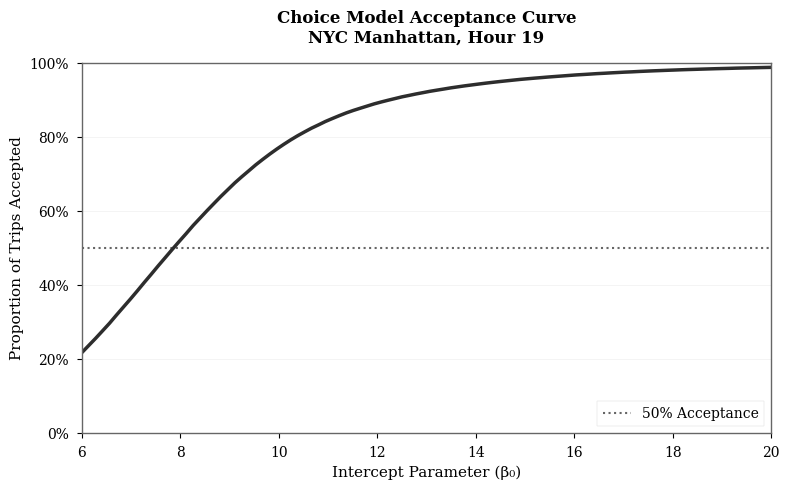


Figure saved to:
  - saved_files/choice_model_acceptance_curve.png
  - saved_files/choice_model_acceptance_curve.pdf


In [8]:
# Create figure
fig, ax = plt.subplots(figsize=(8, 5))

# Plot the main S-curve in gray tones
ax.plot(intercept_range, proportion_accepted, 
        color='#2d2d2d', linewidth=2.5)

# Add horizontal line at 50% acceptance
ax.axhline(y=0.5, color='#666666', linestyle=':', 
           linewidth=1.5, label='50% Acceptance', zorder=1)

# Add horizontal gridlines
ax.grid(True, axis='y', alpha=0.3, linestyle='-', linewidth=0.5, color='#cccccc')
ax.set_axisbelow(True)

# Labels and title
ax.set_xlabel('Intercept Parameter (β₀)', fontsize=11, fontweight='normal')
ax.set_ylabel('Proportion of Trips Accepted', fontsize=11, fontweight='normal')
ax.set_title('Choice Model Acceptance Curve\nNYC Manhattan, Hour 19', 
             fontsize=12, fontweight='bold', pad=15)

# Format y-axis as percentage
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))

# Set axis limits
ax.set_xlim(intercept_range[0], intercept_range[-1])
ax.set_ylim(0, 1.0)

# Add legend
ax.legend(loc='lower right', frameon=True, fancybox=False, 
          shadow=False, framealpha=0.95, edgecolor='#cccccc')

# Adjust spine colors
for spine in ax.spines.values():
    spine.set_edgecolor('#666666')
    spine.set_linewidth(1)

# Tight layout
plt.tight_layout()

# Save figure
plt.savefig('saved_files/choice_model_acceptance_curve.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig('saved_files/choice_model_acceptance_curve.pdf', 
            bbox_inches='tight', facecolor='white')

plt.show()

print("\nFigure saved to:")
print("  - saved_files/choice_model_acceptance_curve.png")
print("  - saved_files/choice_model_acceptance_curve.pdf")

## 8. Additional Analysis: Price and Travel Time Distributions

In [9]:
# Create summary dataframe
summary_df = pd.DataFrame({
    'Intercept': intercept_range,
    'Acceptance_Rate': proportion_accepted,
    'Accepted_Demand': accepted_demand_values
})

# Find key intercept values
idx_10 = np.argmin(np.abs(proportion_accepted - 0.1))
idx_25 = np.argmin(np.abs(proportion_accepted - 0.25))
idx_50 = np.argmin(np.abs(proportion_accepted - 0.5))
idx_75 = np.argmin(np.abs(proportion_accepted - 0.75))
idx_90 = np.argmin(np.abs(proportion_accepted - 0.9))

print("=" * 60)
print("SUMMARY STATISTICS")
print("=" * 60)
print(f"\nTotal demand at hour 19: {total_demand} trips")
print(f"Number of O-D pairs: {len(demand_hour_19)}")
print(f"\nIntercept range tested: {intercept_range[0]:.2f} to {intercept_range[-1]:.2f}")
print(f"\nIntercept values for target acceptance rates:")
print(f"  10% acceptance: β₀ = {intercept_range[idx_10]:.2f}")
print(f"  25% acceptance: β₀ = {intercept_range[idx_25]:.2f}")
print(f"  50% acceptance: β₀ = {intercept_range[idx_50]:.2f}")
print(f"  75% acceptance: β₀ = {intercept_range[idx_75]:.2f}")
print(f"  90% acceptance: β₀ = {intercept_range[idx_90]:.2f}")
print("=" * 60)

# Display sample results
print("\nSample results (every 20th value):")
display(summary_df.iloc[::20].round(3))

SUMMARY STATISTICS

Total demand at hour 19: 61732 trips
Number of O-D pairs: 4677

Intercept range tested: 6.00 to 20.00

Intercept values for target acceptance rates:
  10% acceptance: β₀ = 6.00
  25% acceptance: β₀ = 6.28
  50% acceptance: β₀ = 7.84
  75% acceptance: β₀ = 9.82
  90% acceptance: β₀ = 12.22

Sample results (every 20th value):


,Intercept,Acceptance_Rate,Accepted_Demand
0,6.000,0.218,13454.56
20,8.828,0.641,39564.96
40,11.657,0.879,54260.58
60,14.485,0.951,58707.90
80,17.313,0.978,60391.26
